# HAI-21.03 Dataset Simplified LSTM Analysis (Global Variables)

This notebook implements a simplified LSTM approach with a larger sliding window (192 time steps) for analyzing the HAI-21.03 industrial control system security dataset. All variables are loaded as global variables at the beginning, and the LSTM model complexity is reduced to improve computational efficiency.

In [1]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import itertools
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('ggplot')
sns.set(style="darkgrid")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# Import custom data processor
from hai_data_processor import HAIDataProcessor

## 1. Global Variables Setup

In this section, we set up all global variables, including paths, parameters, and configurations.

In [3]:
# Set paths
DATA_DIR = 'hai-security-dataset/hai-21.03'
OUTPUT_DIR = 'hai-security-dataset/processed'
MODEL_DIR = 'models/simplified_global_en'

# Create model directory if it doesn't exist
os.makedirs(MODEL_DIR, exist_ok=True)

# Set model parameters
SEQ_LENGTH = 128  # Sequence length (time steps)
STRIDE = 10        # Sliding window stride
N_COMPONENTS = 20 # Number of PCA components
N_FEATURES = 50   # Number of features to select
CORRELATION_THRESHOLD = 0.7  # Graph edge correlation threshold
MIN_ANOMALY_LENGTH = 30      # Minimum anomaly length
GAP_THRESHOLD = 3            # Maximum gap to merge anomalies

# Set training parameters
EPOCHS = 5
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
PATIENCE = 5
LEARNING_RATE = 0.001

# Set anomaly detection parameters
ANOMALY_SCORE_THRESHOLD = 0.65  # Anomaly score threshold
CONTAMINATION = 0.005           # Contamination rate for dynamic threshold

## 2. Data Loading and Processing

Load the HAI-21.03 dataset and perform initial processing.

In [4]:
# Initialize data processor
processor = HAIDataProcessor(DATA_DIR, OUTPUT_DIR)

# Load data
processor.load_data()

# Get all training data and merge
train_df = processor.merge_train_data()

# Print dataset information
print(f"Training data shape: {train_df.shape}")
print(f"Training data columns: {train_df.columns[:10].tolist()}...")

# Get test dataset information
print("\nTest datasets:")
for name, df in processor.test_data.items():
    print(f"  {name}: {df.shape}")

Found 3 train files and 5 test files
Loading train files: 

Loading train files:  33%|███▎      | 1/3 [00:02<00:05,  2.97s/it]

train1: 216001 rows, 84 columns


Loading train files:  67%|██████▋   | 2/3 [00:05<00:02,  3.00s/it]

train2: 226801 rows, 84 columns


Loading train files: 100%|██████████| 3/3 [00:12<00:00,  4.04s/it]


train3: 478801 rows, 84 columns
Loading test files: 

Loading test files:  20%|██        | 1/5 [00:00<00:02,  1.80it/s]

test1: 43201 rows, 84 columns


Loading test files:  40%|████      | 2/5 [00:02<00:03,  1.11s/it]

test2: 118801 rows, 84 columns


Loading test files:  60%|██████    | 3/5 [00:03<00:02,  1.25s/it]

test3: 108001 rows, 84 columns


Loading test files:  80%|████████  | 4/5 [00:03<00:00,  1.05it/s]

test4: 39601 rows, 84 columns


Loading test files: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]

test5: 92401 rows, 84 columns


Merged training data: 921603 rows, 84 columns
Training data shape: (921603, 84)
Training data columns: ['time', 'p1_b2004', 'p1_b2016', 'p1_b3004', 'p1_b3005', 'p1_b4002', 'p1_b4005', 'p1_b400b', 'p1_b4022', 'p1_fcv01d']...

Test datasets:
  test1: (43201, 84)
  test2: (118801, 84)
  test3: (108001, 84)
  test4: (39601, 84)
  test5: (92401, 84)


## 3. Graph Structure Creation

Create a graph structure to understand the relationships between different components.

In [5]:
def create_graph_from_columns(df, correlation_threshold=0.7):
    """
    Create a graph structure based on column names and their correlations.
    
    Args:
        df (pd.DataFrame): DataFrame with sensor/actuator columns
        correlation_threshold (float): Threshold for adding edges between components in the graph
        
    Returns:
        nx.Graph: NetworkX graph representing the system
    """
    G = nx.Graph()
    
    # Extract columns excluding time and attack columns
    cols = [col for col in df.columns if not col.startswith('time') and not col.startswith('attack')]
    
    # Add nodes for each subsystem
    subsystems = ['P1', 'P2', 'P3', 'P4']
    for subsystem in subsystems:
        G.add_node(subsystem, type='subsystem')
    
    # Add nodes for each sensor/actuator
    for col in cols:
        parts = col.split('_')
        if len(parts) >= 2:
            subsystem = parts[0]
            component = '_'.join(parts[1:])
            
            # Add node for component
            G.add_node(col, type='component', subsystem=subsystem)
            
            # Add edge between component and its subsystem
            G.add_edge(subsystem, col, weight=1.0)
    
    # Add edges between components based on correlation
    corr_matrix = df[cols].corr().abs()
    
    for i, col1 in enumerate(cols):
        for j, col2 in enumerate(cols):
            if i < j and corr_matrix.loc[col1, col2] > correlation_threshold:
                G.add_edge(col1, col2, weight=corr_matrix.loc[col1, col2])
    
    return G

# Create graph
G = create_graph_from_columns(train_df, CORRELATION_THRESHOLD)

# Print graph statistics
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Safely count node types
node_types_count = {}
for _, data in G.nodes(data=True):
    if 'type' in data:
        node_type = data['type']
        if node_type not in node_types_count:
            node_types_count[node_type] = 0
        node_types_count[node_type] += 1

print(f"\nNode types:")
for node_type, count in node_types_count.items():
    print(f"  {node_type}: {count}")

Number of nodes: 87
Number of edges: 180

Node types:
  subsystem: 4
  component: 79


Showing subgraph with 50 nodes and 146 edges


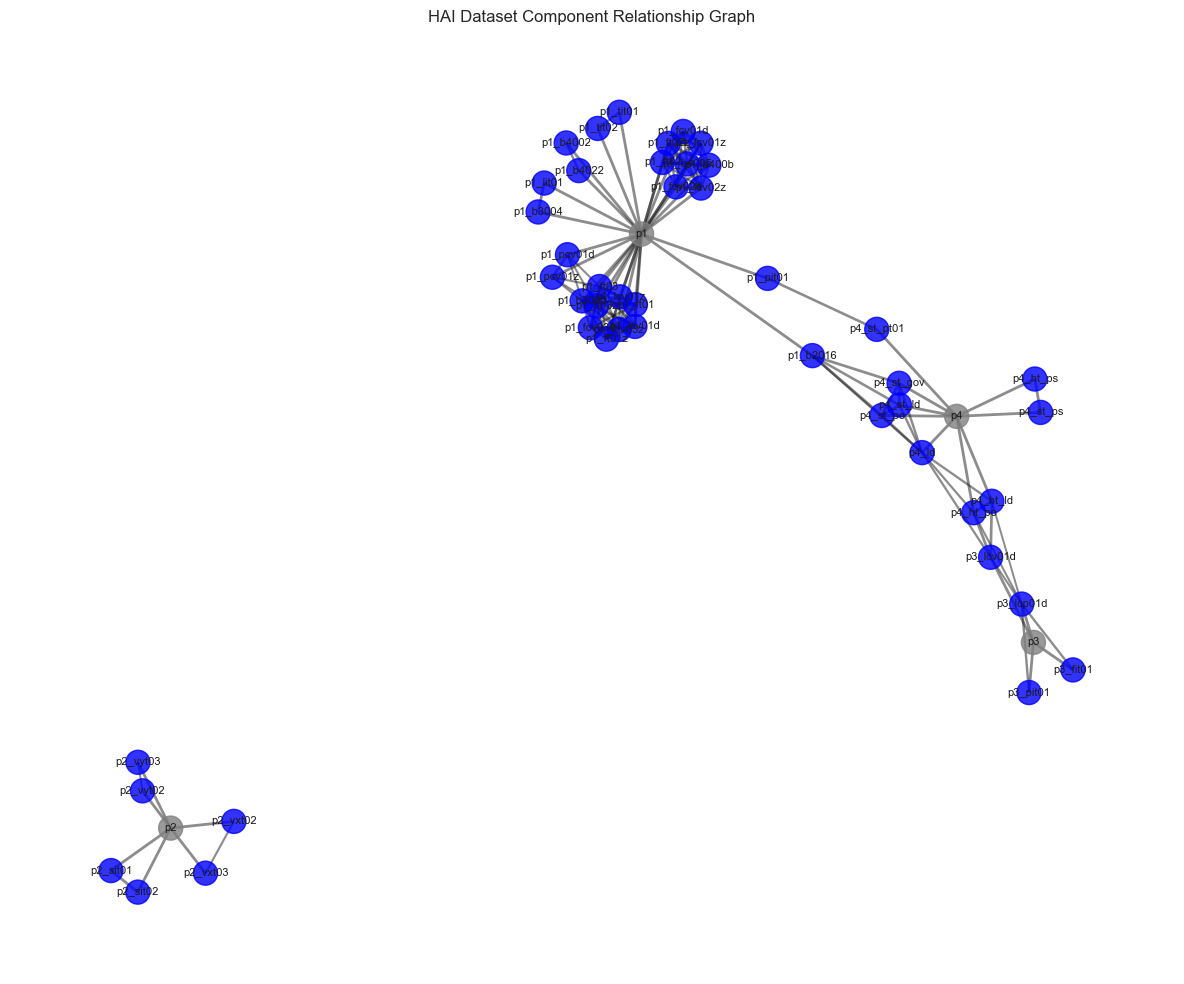

In [6]:
# Visualize graph
def visualize_graph(G, max_nodes=50):
    """
    Visualize a graph, limiting to max_nodes if the graph is too large.
    
    Args:
        G (nx.Graph): NetworkX graph
        max_nodes (int): Maximum number of nodes to display
    """
    if G.number_of_nodes() > max_nodes:
        # Get the most connected nodes
        degrees = dict(G.degree())
        top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:max_nodes]
        G_sub = G.subgraph(top_nodes)
        print(f"Showing subgraph with {G_sub.number_of_nodes()} nodes and {G_sub.number_of_edges()} edges")
        G_vis = G_sub
    else:
        G_vis = G
    
    plt.figure(figsize=(12, 10))
    
    # Set node colors based on type (safely)
    node_colors = []
    for node in G_vis.nodes():
        node_type = G_vis.nodes[node].get('type', 'unknown')
        if node_type == 'subsystem':
            node_colors.append('red')
        elif node_type == 'component':
            node_colors.append('blue')
        else:
            node_colors.append('gray')
    
    # Set edge widths based on weight
    edge_widths = [G_vis[u][v].get('weight', 1.0) * 2 for u, v in G_vis.edges()]
    
    # Draw the graph
    pos = nx.spring_layout(G_vis, seed=42)
    nx.draw_networkx_nodes(G_vis, pos, node_color=node_colors, node_size=300, alpha=0.8)
    nx.draw_networkx_edges(G_vis, pos, width=edge_widths, alpha=0.5)
    nx.draw_networkx_labels(G_vis, pos, font_size=8)
    
    plt.title("HAI Dataset Component Relationship Graph")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize graph
visualize_graph(G)

## 4. Simplified Graph Feature Engineering

Create simplified features using the graph structure.

In [7]:
def simplified_graph_based_feature_engineering(df, G):
    """
    Create simplified graph-based features.
    
    Args:
        df (pd.DataFrame): DataFrame with sensor/actuator data
        G (nx.Graph): NetworkX graph
        
    Returns:
        pd.DataFrame: DataFrame with additional graph-based features
    """
    df_processed = df.copy()
    
    # Extract columns excluding time and attack columns
    cols = [col for col in df.columns if not col.startswith('time') and not col.startswith('attack')]
    
    # Add subsystem-level features (simplified)
    for subsystem in ['P1', 'P2', 'P3', 'P4']:
        subsystem_cols = [col for col in cols if col.startswith(f"{subsystem}_")]
        if subsystem_cols:
            # Calculate subsystem-level statistics (reduced set)
            df_processed[f"{subsystem}_graph_mean"] = df[subsystem_cols].mean(axis=1)
            df_processed[f"{subsystem}_graph_std"] = df[subsystem_cols].std(axis=1)
            df_processed[f"{subsystem}_graph_max"] = df[subsystem_cols].max(axis=1)
            df_processed[f"{subsystem}_graph_min"] = df[subsystem_cols].min(axis=1)
    
    # Add cross-subsystem features (simplified)
    subsystems = ['P1', 'P2', 'P3', 'P4']
    for i, s1 in enumerate(subsystems):
        for j, s2 in enumerate(subsystems):
            if i < j:
                # Calculate ratio and difference between subsystem means
                if f"{s1}_graph_mean" in df_processed.columns and f"{s2}_graph_mean" in df_processed.columns:
                    s2_mean = df_processed[f"{s2}_graph_mean"].replace(0, 1e-10)  # Avoid division by zero
                    df_processed[f"{s1}_{s2}_ratio"] = df_processed[f"{s1}_graph_mean"] / s2_mean
                    df_processed[f"{s1}_{s2}_diff"] = df_processed[f"{s1}_graph_mean"] - df_processed[f"{s2}_graph_mean"]
    
    # Add rolling window features (simplified)
    window_sizes = [10]  # Reduced to just one window size
    for window in window_sizes:
        for subsystem in subsystems:
            col = f"{subsystem}_graph_mean"
            if col in df_processed.columns:
                df_processed[f"{col}_rolling_{window}_mean"] = df_processed[col].rolling(window=window).mean()
                df_processed[f"{col}_rolling_{window}_std"] = df_processed[col].rolling(window=window).std()
    
    # Fill NaN values
    df_processed = df_processed.fillna(method='bfill').fillna(method='ffill')
    
    return df_processed

# Apply simplified graph feature engineering
train_df_processed = simplified_graph_based_feature_engineering(train_df, G)

# Print feature counts
print(f"Original train features: {train_df.shape[1]}")
print(f"Processed train features: {train_df_processed.shape[1]}")
print(f"New features added: {train_df_processed.shape[1] - train_df.shape[1]}")

Original train features: 84
Processed train features: 84
New features added: 0


## 5. Feature Selection and Dimensionality Reduction

Select the most relevant features and reduce dimensionality.

In [8]:
# Exclude non-numeric and target columns
exclude_cols = ['time', 'attack', 'attack_P1', 'attack_P2', 'attack_P3']
feature_cols = [col for col in train_df_processed.columns if col not in exclude_cols and 
                pd.api.types.is_numeric_dtype(train_df_processed[col])]

# Calculate feature importance (using variance)
variances = train_df_processed[feature_cols].var()
feature_importance = {feature: score for feature, score in zip(feature_cols, variances)}

# Select top features
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
top_features = [f[0] for f in sorted_features[:min(N_FEATURES, len(sorted_features))]]

# Extract features
X_train_features = train_df_processed[top_features].values

# Scale data using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_features)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=N_COMPONENTS)
X_train_pca = pca.fit_transform(X_train_scaled)

print(f"Explained variance ratio: {np.sum(pca.explained_variance_ratio_):.4f}")
print(f"Selected {len(top_features)} features out of {len(feature_cols)}")

Explained variance ratio: 0.9988
Selected 50 features out of 82


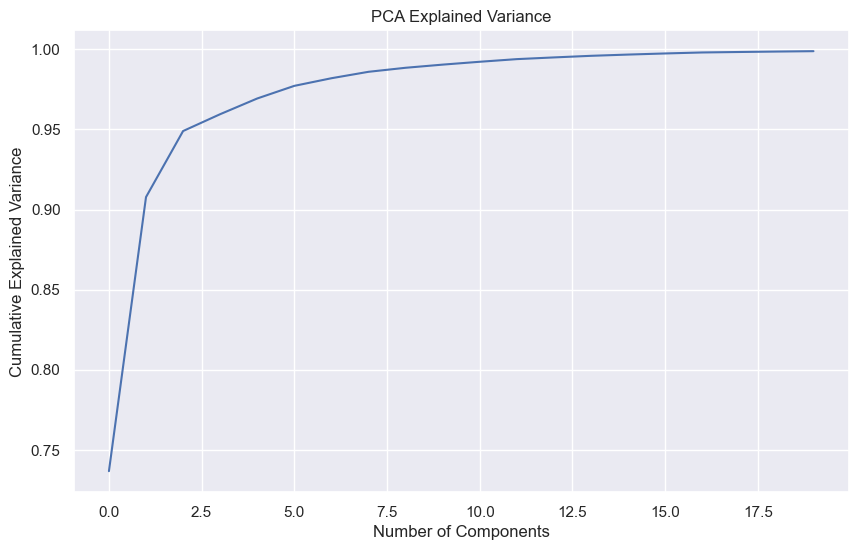

In [9]:
# Visualize PCA components
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

## 6. Time Series Preprocessing

Create sequences for time series modeling with a larger window.

In [10]:
def create_sequences(data, seq_length=192, stride=8):
    """
    Create sequences for time series models with larger window.
    
    Args:
        data (np.array): Input data
        seq_length (int): Sequence length (default 192)
        stride (int): Stride for sliding window
        
    Returns:
        np.array: Sequences
    """
    sequences = []
    for i in range(0, len(data) - seq_length + 1, stride):
        seq = data[i:i+seq_length]
        sequences.append(seq)
    
    return np.array(sequences)

# Create sequences
X_train_seq = create_sequences(X_train_pca, SEQ_LENGTH, STRIDE)

print("Training sequences shape:", X_train_seq.shape)

Training sequences shape: (92148, 128, 20)


## 7. Simplified LSTM Autoencoder Model

Build a simplified LSTM autoencoder model for anomaly detection with reduced complexity.

In [11]:
def build_simplified_lstm_autoencoder(seq_length, n_features):
    """
    Build a simplified LSTM autoencoder model with reduced complexity.
    
    Args:
        seq_length (int): Sequence length
        n_features (int): Number of features
        
    Returns:
        Model: Keras model
    """
    # Input layer
    inputs = Input(shape=(seq_length, n_features), name='input_layer')
    
    # Encoder - simplified to just one LSTM layer
    x = LSTM(16, activation='tanh', return_sequences=False)(inputs)
    x = LayerNormalization()(x)
    x = Dropout(0.2)(x)
    
    # Bottleneck
    encoded = Dense(8, activation='relu')(x)
    
    # Decoder - simplified
    x = Dense(16, activation='relu')(encoded)
    x = tf.keras.layers.RepeatVector(seq_length)(x)
    
    x = LSTM(16, activation='tanh', return_sequences=True)(x)
    x = LayerNormalization()(x)
    x = Dropout(0.2)(x)
    
    # Output layer
    outputs = tf.keras.layers.TimeDistributed(Dense(n_features))(x)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile model
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mse')
    
    return model

# Build model
print("Building simplified LSTM autoencoder model...")
model = build_simplified_lstm_autoencoder(SEQ_LENGTH, X_train_pca.shape[1])

# Print model summary
model.summary()

Building simplified LSTM autoencoder model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16)             │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 16)             │            32 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 128, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128, 16)        │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 128, 16)        │            32 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 128, 20)        │           340 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,164 (20.17 KB)

 Trainable params: 5,164 (20.17 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train model
print("Training simplified LSTM autoencoder model...")

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001),
    ModelCheckpoint(f'{MODEL_DIR}/simplified_lstm.h5', monitor='val_loss', save_best_only=True)
]

# Train model
history = model.fit(
    X_train_seq, X_train_seq,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    callbacks=callbacks,
    verbose=1
)

Training simplified LSTM autoencoder model...
Epoch 1/5
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 10.8798

2304/2304 ━━━━━━━━━━━━━━━━━━━━ 137s 55ms/step - loss: 10.8781 - val_loss: 2.9006 - learning_rate: 0.0010
Epoch 2/5
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 3.9156

2304/2304 ━━━━━━━━━━━━━━━━━━━━ 124s 54ms/step - loss: 3.9156 - val_loss: 2.4917 - learning_rate: 0.0010
Epoch 3/5
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 3.6659

2304/2304 ━━━━━━━━━━━━━━━━━━━━ 126s 55ms/step - loss: 3.6659 - val_loss: 2.4294 - learning_rate: 0.0010
Epoch 4/5
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 3.5675

2304/2304 ━━━━━━━━━━━━━━━━━━━━ 125s 54ms/step - loss: 3.5675 - val_loss: 2.3644 - learning_rate: 0.0010
Epoch 5/5
2304/2304 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 3.5120

2304/2304 ━━━━━━━━━━━━━━━━━━━━ 121s 52ms/step - loss: 3.5120 - val_loss: 2.2927 - learning_rate: 0.0010


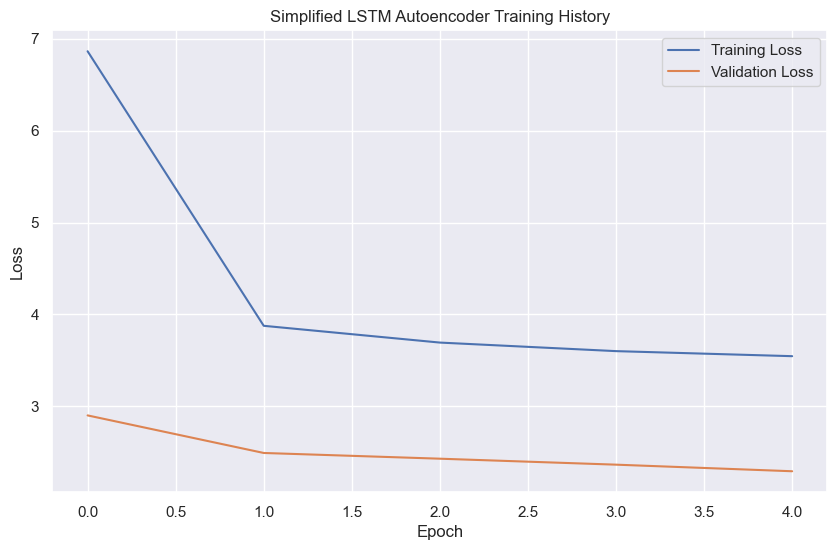

In [13]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Simplified LSTM Autoencoder Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## 8. Determine Anomaly Detection Threshold

Determine the threshold for anomaly detection.

In [14]:
def determine_threshold(model, X_train_seq, method='dynamic', contamination=0.01, percentile=99):
    """
    Determine threshold for anomaly detection.
    
    Args:
        model (Model): Trained model
        X_train_seq (np.array): Training sequences
        method (str): Method for threshold determination ('dynamic', 'percentile', or 'iqr')
        contamination (float): Expected proportion of anomalies (for dynamic method)
        percentile (float): Percentile for threshold (for percentile method)
        
    Returns:
        float: Threshold value
    """
    # Get predictions from model
    X_train_pred = model.predict(X_train_seq)
    train_mse = np.mean(np.square(X_train_seq - X_train_pred), axis=(1, 2))
    
    if method == 'dynamic':
        # Simulate anomalies using highest reconstruction errors
        simulated_anomalies = np.zeros(len(train_mse))
        anomaly_count = int(contamination * len(train_mse))
        anomaly_indices = np.argsort(train_mse)[-anomaly_count:]
        simulated_anomalies[anomaly_indices] = 1
        
        # Calculate precision-recall curve
        from sklearn.metrics import precision_recall_curve
        precisions, recalls, thresholds = precision_recall_curve(simulated_anomalies, train_mse)
        
        # Find threshold that maximizes F1 score
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
        optimal_idx = np.argmax(f1_scores)
        threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else thresholds[-1]
        
    elif method == 'percentile':
        # Use percentile method
        threshold = np.percentile(train_mse, percentile)
        
    elif method == 'iqr':
        # Use IQR method
        q1 = np.percentile(train_mse, 25)
        q3 = np.percentile(train_mse, 75)
        iqr = q3 - q1
        threshold = q3 + 1.5 * iqr
        
    else:
        raise ValueError(f"Unknown threshold method: {method}")
    
    return threshold

# Determine threshold
threshold = determine_threshold(model, X_train_seq, method='dynamic', contamination=CONTAMINATION)
print(f"Dynamic threshold: {threshold:.6f}")

# Also calculate IQR threshold for comparison
iqr_threshold = determine_threshold(model, X_train_seq, method='iqr')
print(f"IQR-based threshold: {iqr_threshold:.6f}")

# Also calculate percentile threshold for comparison
percentile_threshold = determine_threshold(model, X_train_seq, method='percentile', percentile=99)
print(f"Percentile-based threshold: {percentile_threshold:.6f}")

# Save threshold
with open(f'{MODEL_DIR}/threshold.txt', 'w') as f:
    f.write(str(threshold))

2880/2880 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step
Dynamic threshold: 31.753098
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 36s 12ms/step
IQR-based threshold: 4.864699
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 36s 13ms/step
Percentile-based threshold: 21.133301


## 9. Anomaly Detection Functions

Define functions for detecting anomalies.

In [15]:
def detect_anomalies(model, X_test_seq, seq_length, stride, data_length, threshold, anomaly_score_threshold=0.65):
    """
    Detect anomalies using the trained model.
    
    Args:
        model (Model): Trained model
        X_test_seq (np.array): Test sequences
        seq_length (int): Sequence length
        stride (int): Stride used for sequences
        data_length (int): Original data length
        threshold (float): Anomaly detection threshold
        anomaly_score_threshold (float): Anomaly score threshold
        
    Returns:
        tuple: (anomaly_scores, anomaly_labels)
    """
    # Get predictions from model
    X_test_pred = model.predict(X_test_seq)
    mse = np.mean(np.square(X_test_seq - X_test_pred), axis=(1, 2))
    
    # Initialize anomaly scores array
    anomaly_scores = np.zeros(data_length)
    count = np.zeros(data_length)
    
    # For each sequence, if it's anomalous, increment the score for all points in the sequence
    for i, error in enumerate(mse):
        idx = i * stride
        if idx + seq_length <= data_length:
            if error > threshold:
                anomaly_scores[idx:idx+seq_length] += 1
            count[idx:idx+seq_length] += 1
    
    # Normalize scores by count
    anomaly_scores = np.divide(anomaly_scores, count, out=np.zeros_like(anomaly_scores), where=count!=0)
    
    # Apply threshold to get binary labels
    anomaly_labels = (anomaly_scores > anomaly_score_threshold).astype(int)
    
    # Apply post-processing
    anomaly_labels = post_process_anomalies(anomaly_labels, min_anomaly_length=MIN_ANOMALY_LENGTH, gap_threshold=GAP_THRESHOLD)
    
    return anomaly_scores, anomaly_labels

def post_process_anomalies(anomaly_labels, min_anomaly_length=30, gap_threshold=3):
    """
    Apply post-processing to reduce false positives and false negatives.
    
    Args:
        anomaly_labels (np.array): Binary anomaly labels
        min_anomaly_length (int): Minimum length of anomalies to keep
        gap_threshold (int): Maximum gap between anomalies to merge
        
    Returns:
        np.array: Processed binary anomaly labels
    """
    # Make a copy to avoid modifying the original
    processed_labels = anomaly_labels.copy()
    
    # Remove short anomalies (likely false positives)
    i = 0
    while i < len(processed_labels):
        if processed_labels[i] == 1:
            # Find the end of this anomaly
            j = i
            while j < len(processed_labels) and processed_labels[j] == 1:
                j += 1
            
            # If anomaly is too short, remove it
            if j - i < min_anomaly_length:
                processed_labels[i:j] = 0
            
            i = j
        else:
            i += 1
    
    # Merge nearby anomalies
    i = 0
    while i < len(processed_labels):
        if processed_labels[i] == 1:
            # Find the end of this anomaly
            j = i
            while j < len(processed_labels) and processed_labels[j] == 1:
                j += 1
            
            # Look for another anomaly nearby
            if j < len(processed_labels) - gap_threshold:
                next_start = j
                while next_start < j + gap_threshold and next_start < len(processed_labels) and processed_labels[next_start] == 0:
                    next_start += 1
                
                if next_start < j + gap_threshold and next_start < len(processed_labels) and processed_labels[next_start] == 1:
                    processed_labels[j:next_start] = 1
            
            i = j
        else:
            i += 1
    
    return processed_labels

## 10. Evaluate Model on Test Data

Evaluate the trained model on all test files.


Evaluating test file: test1
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Precision: 0.6882
Recall: 0.8315
F1 Score: 0.7531
Accuracy: 0.9921
False Positive Rate: 0.0056
False Negative Rate: 0.1685


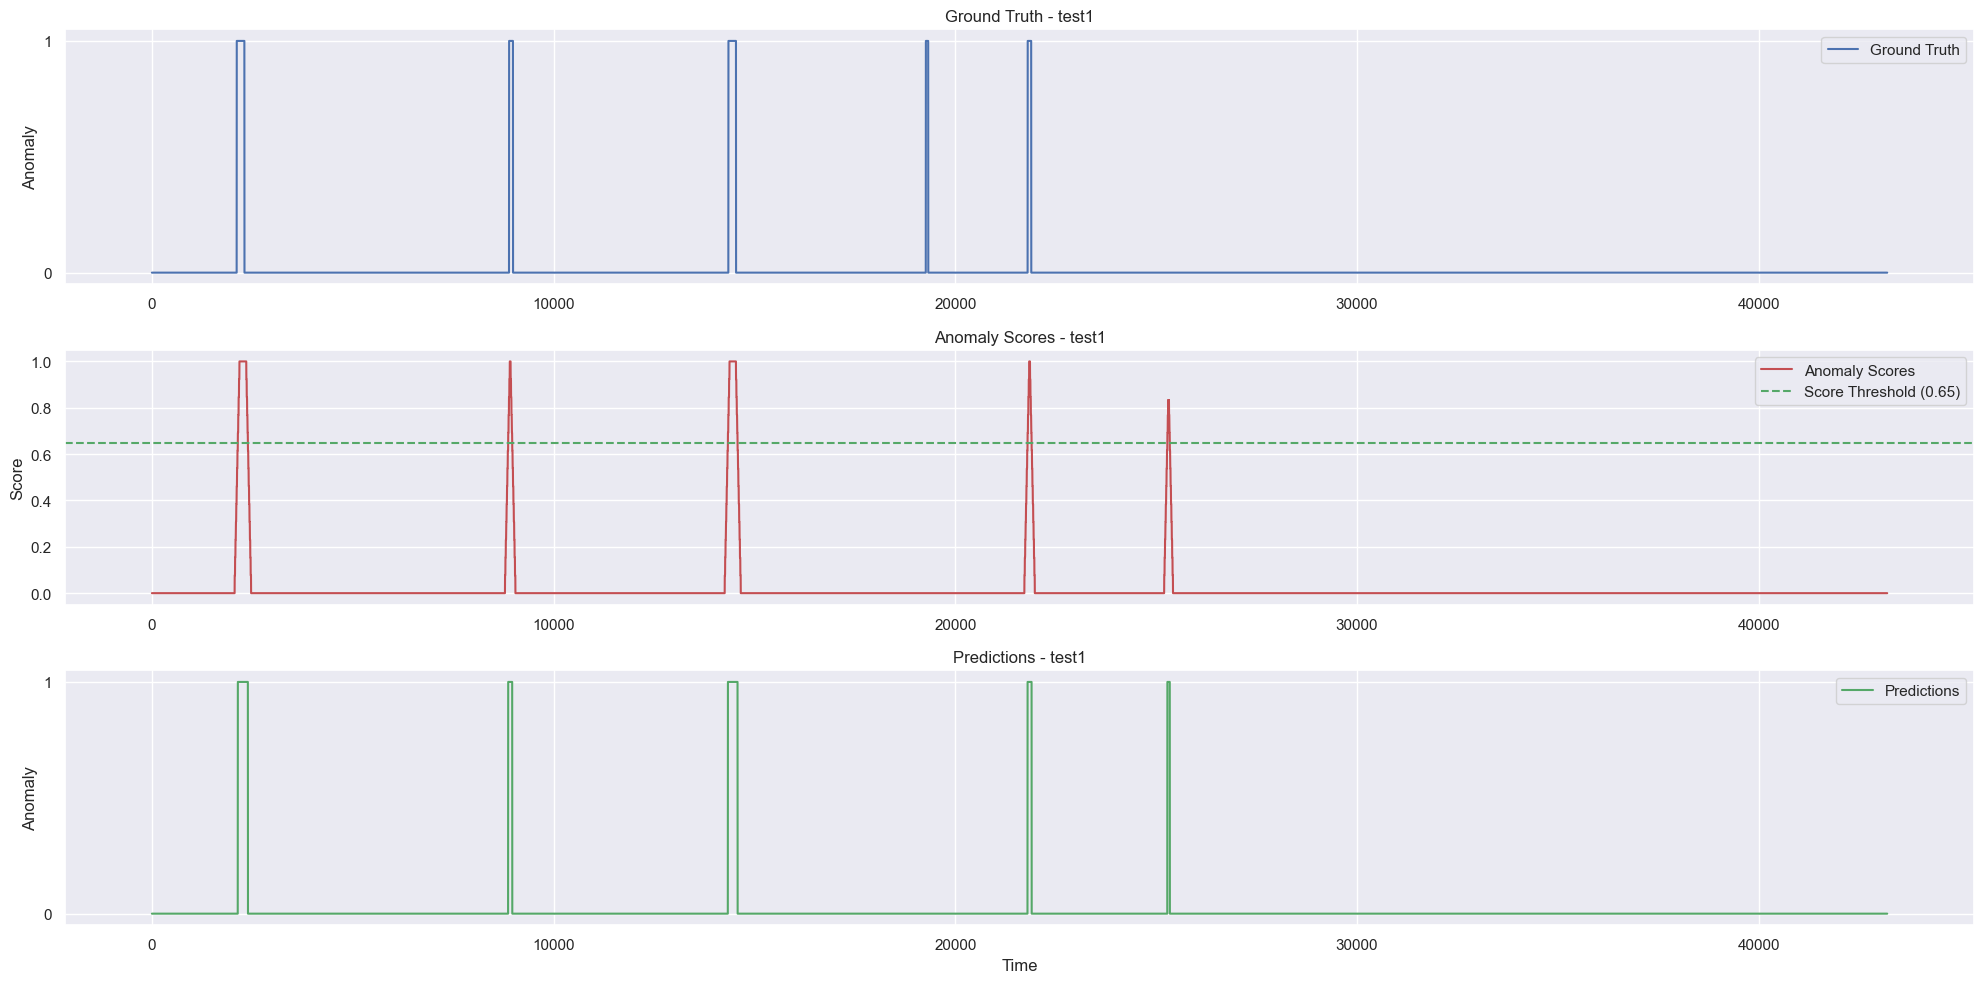

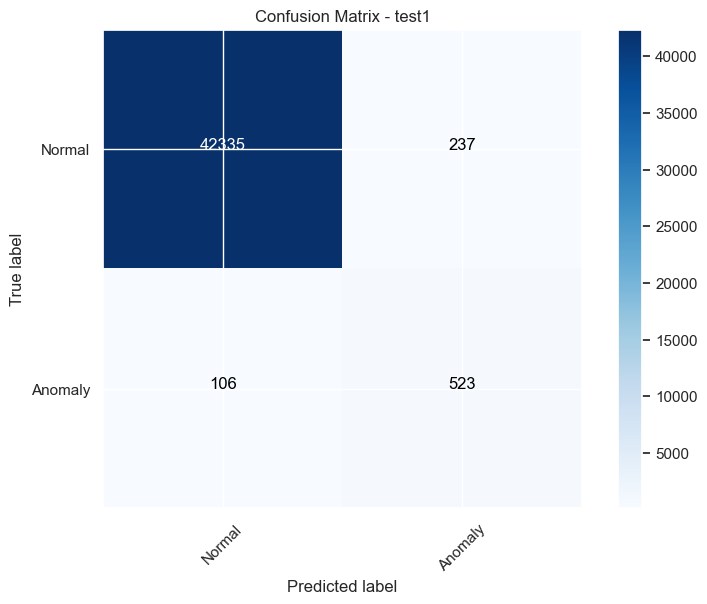


Evaluating test file: test2
371/371 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
Precision: 0.6137
Recall: 0.3850
F1 Score: 0.4732
Accuracy: 0.9751
False Positive Rate: 0.0072
False Negative Rate: 0.6150


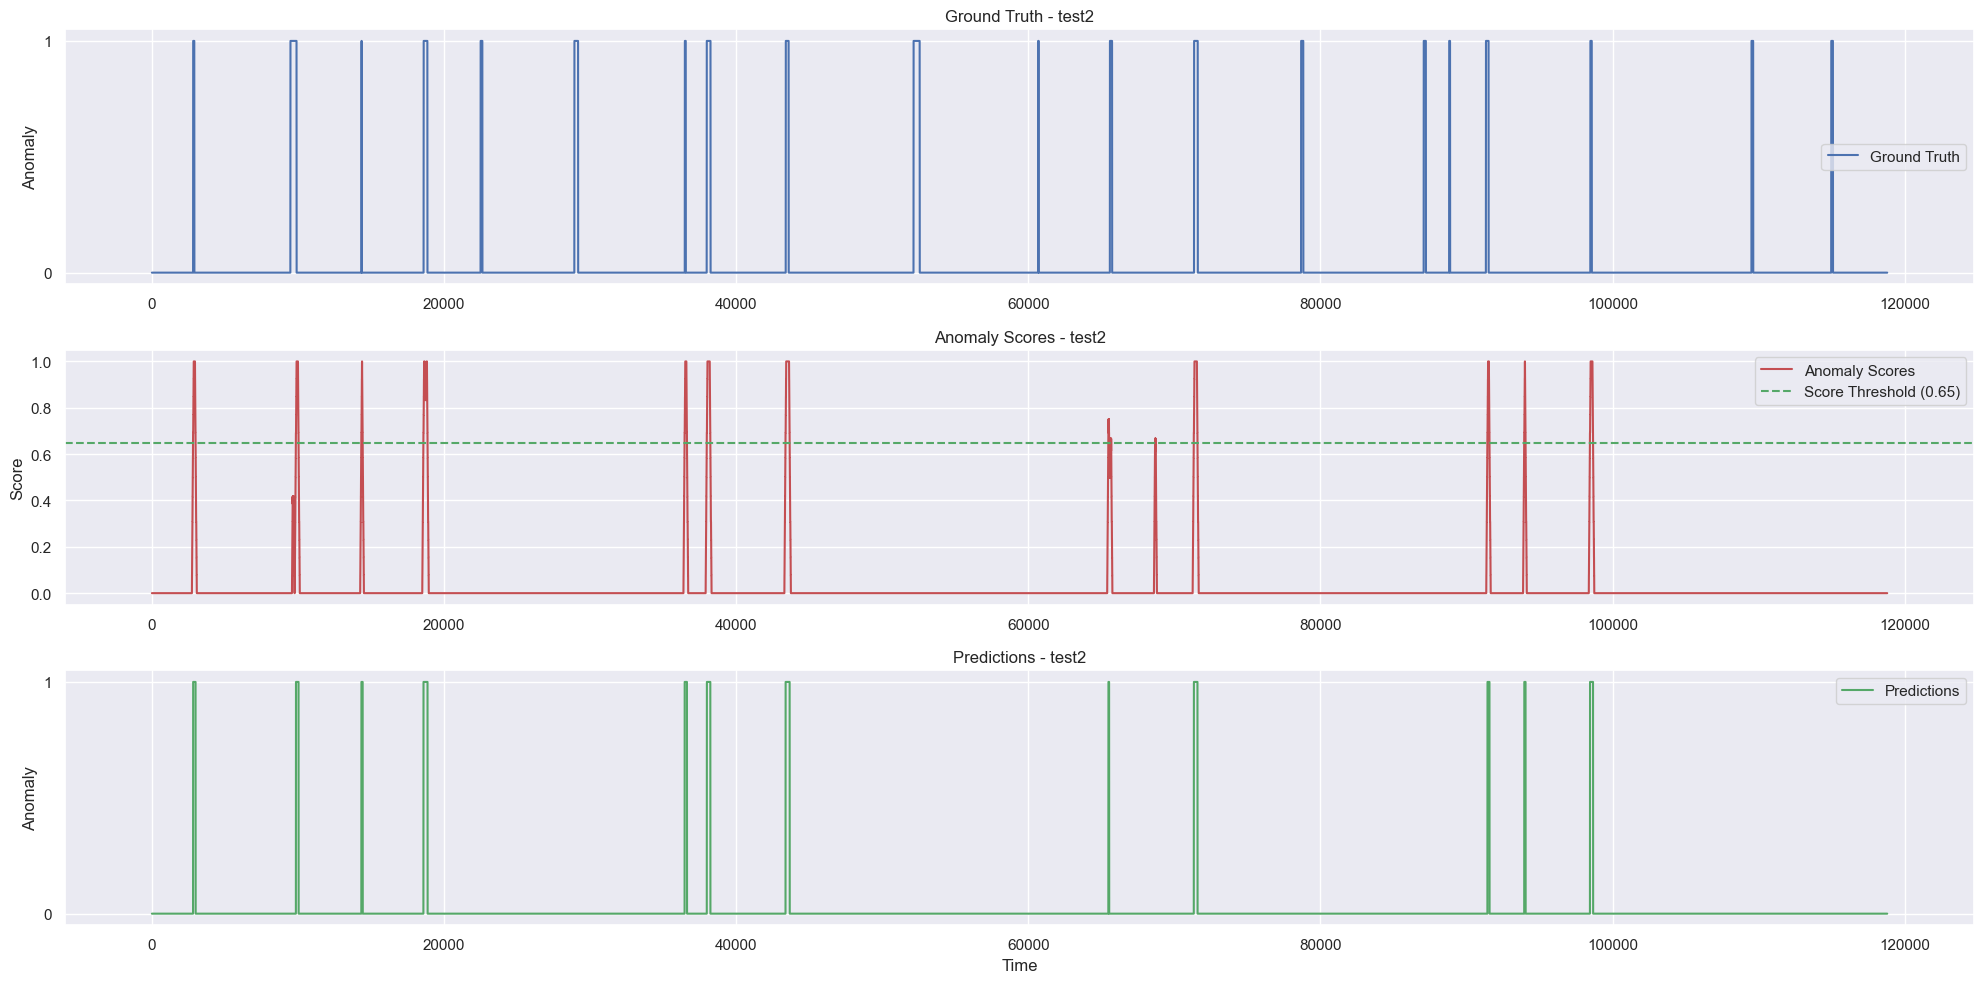

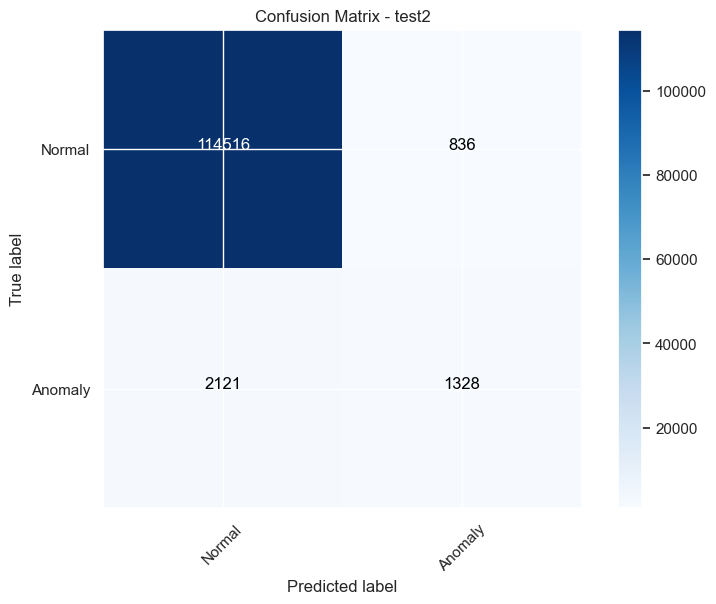


Evaluating test file: test3
338/338 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Precision: 0.6033
Recall: 0.6280
F1 Score: 0.6154
Accuracy: 0.9888
False Positive Rate: 0.0060
False Negative Rate: 0.3720


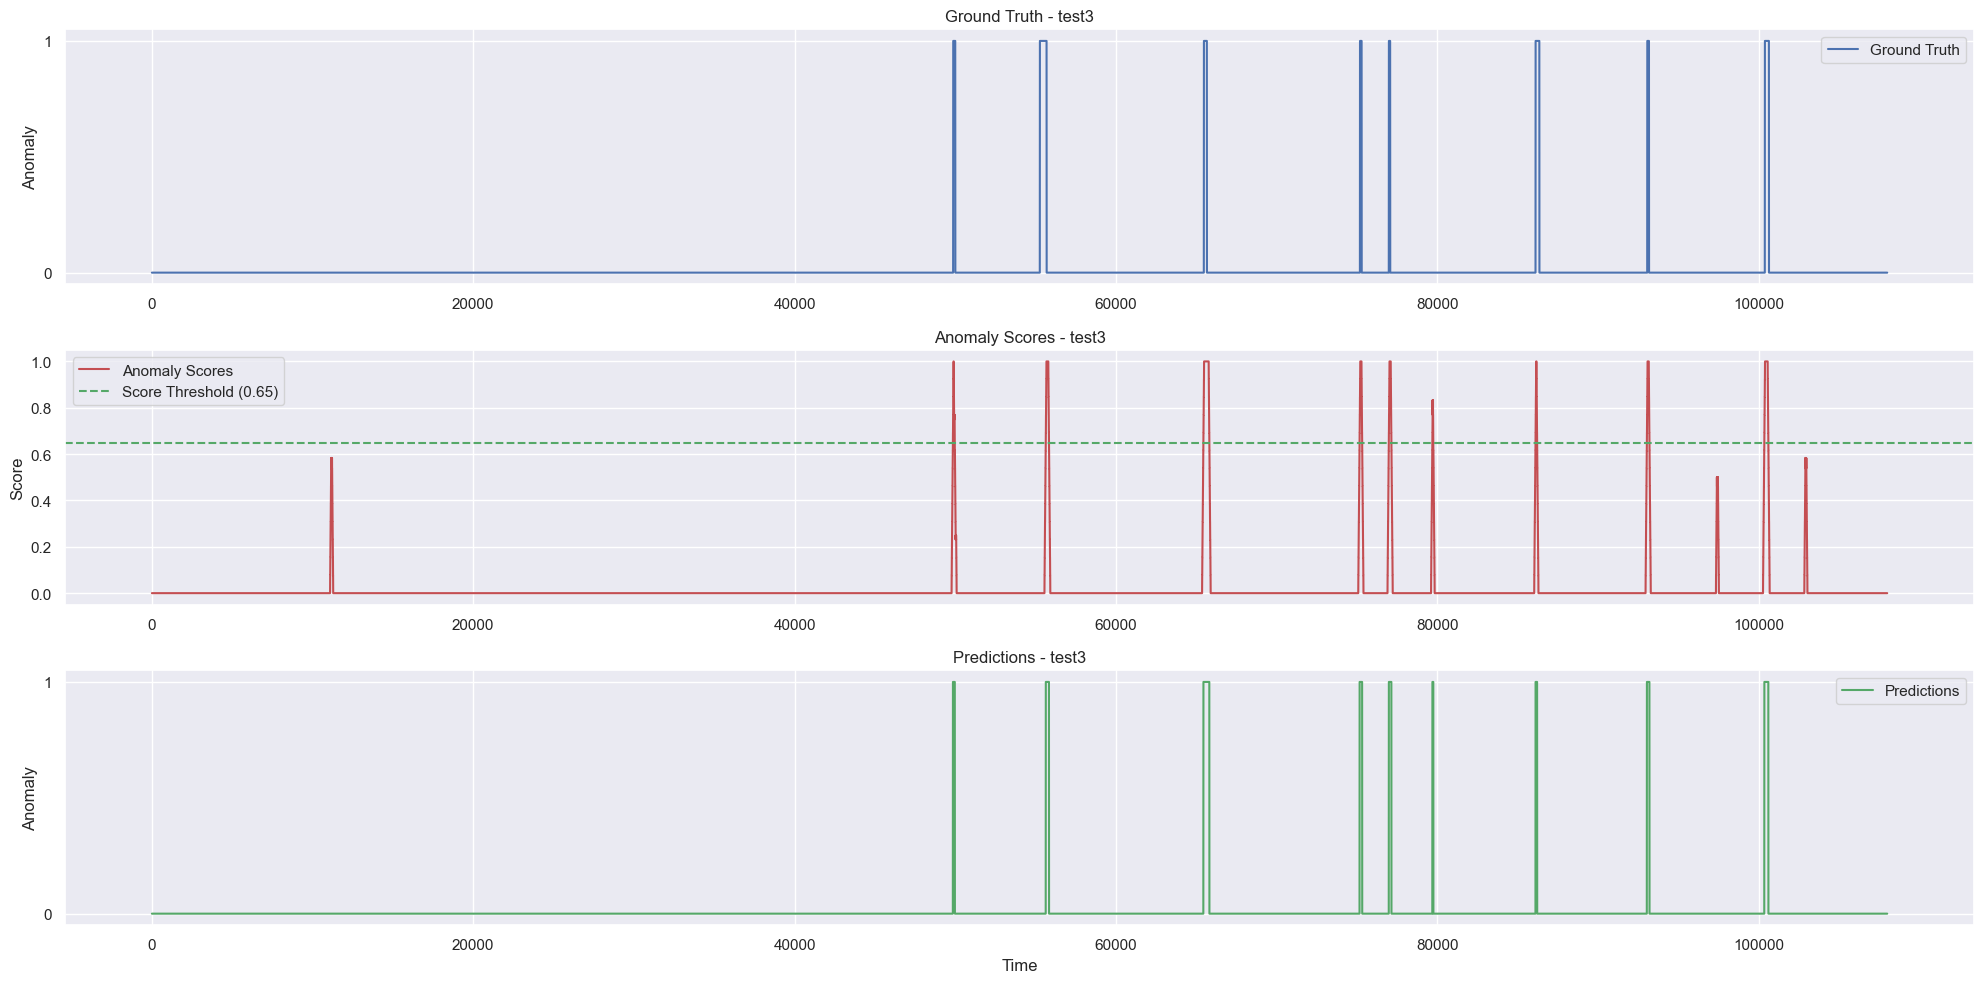

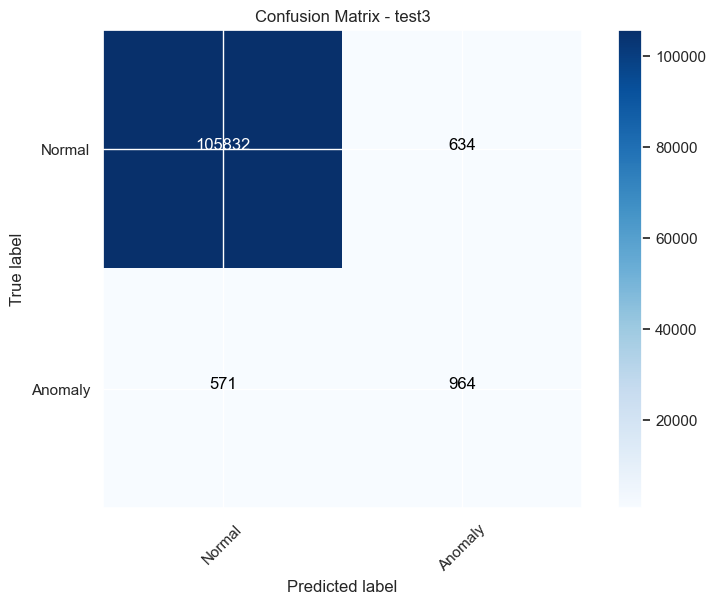


Evaluating test file: test4
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Precision: 0.7739
Recall: 0.8963
F1 Score: 0.8306
Accuracy: 0.9893
False Positive Rate: 0.0079
False Negative Rate: 0.1037


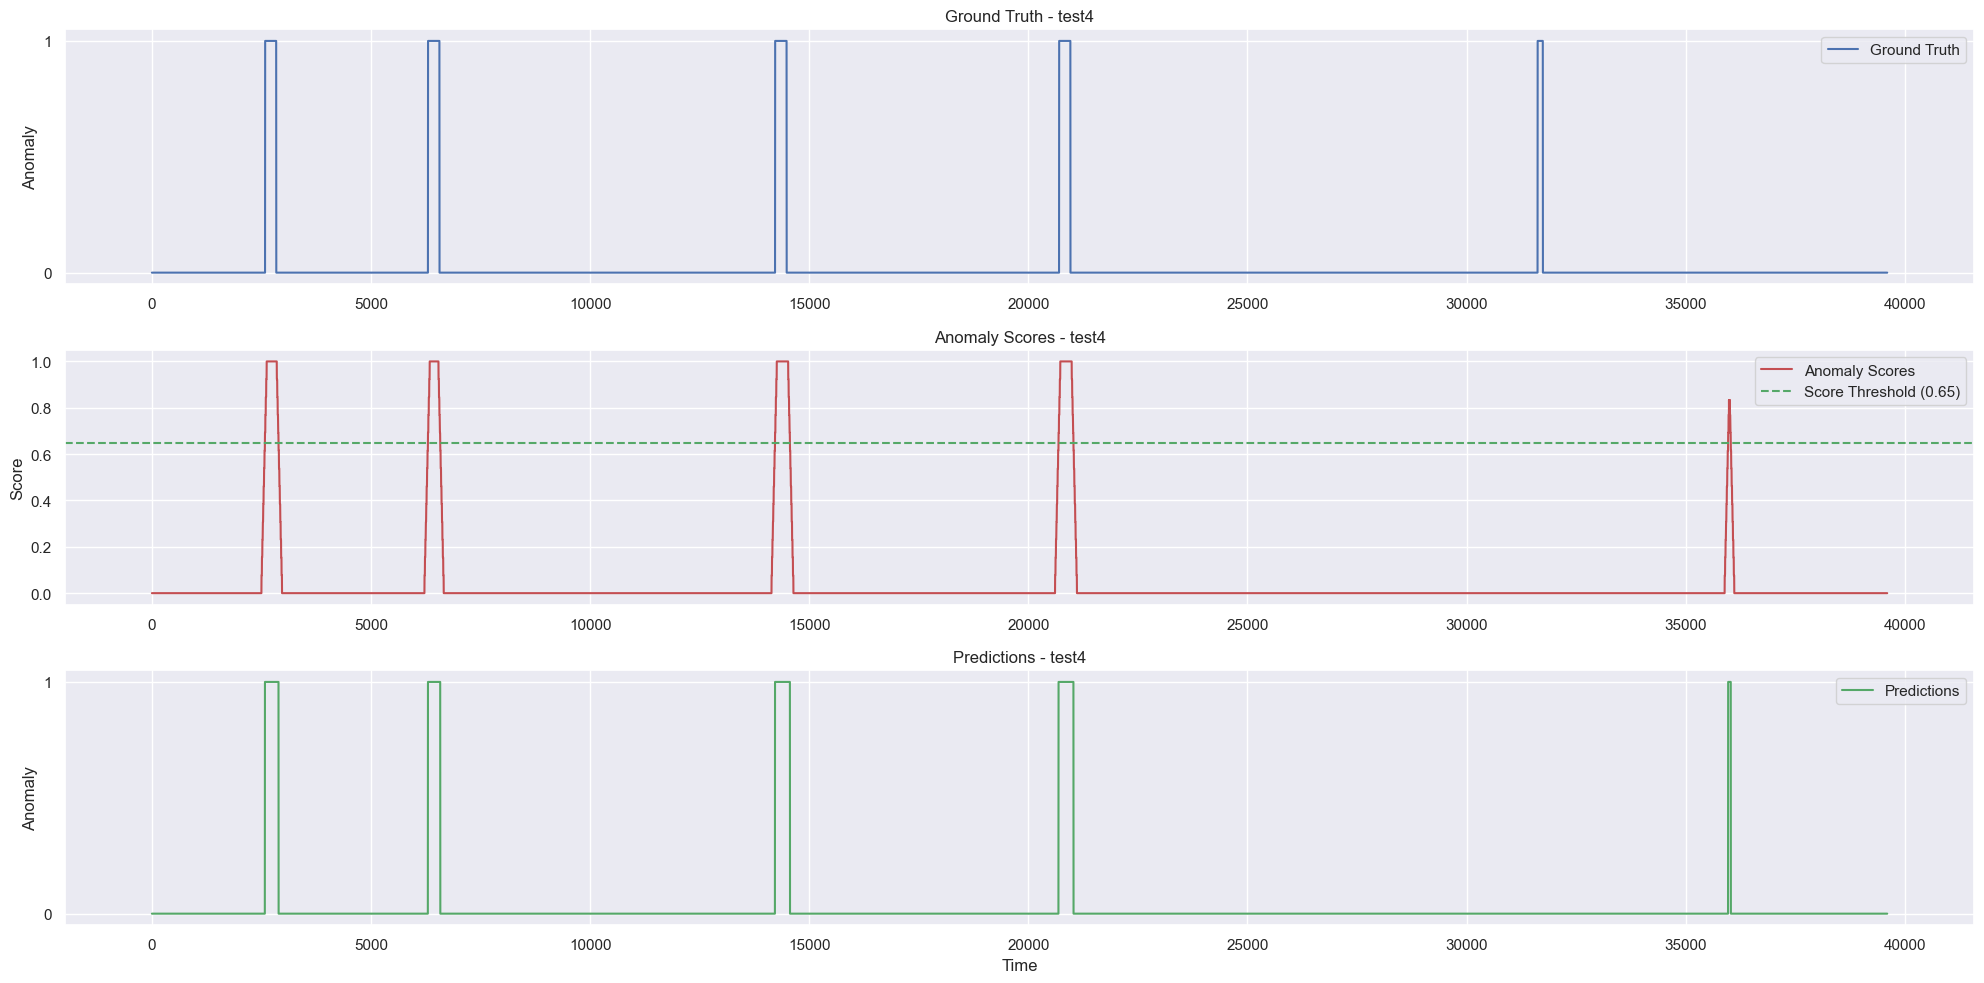

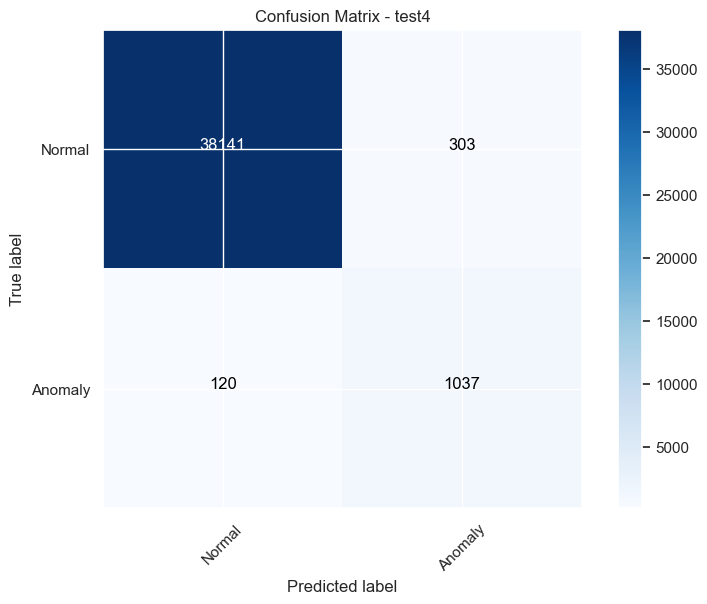


Evaluating test file: test5
289/289 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
Precision: 0.5956
Recall: 0.7327
F1 Score: 0.6571
Accuracy: 0.9820
False Positive Rate: 0.0120
False Negative Rate: 0.2673


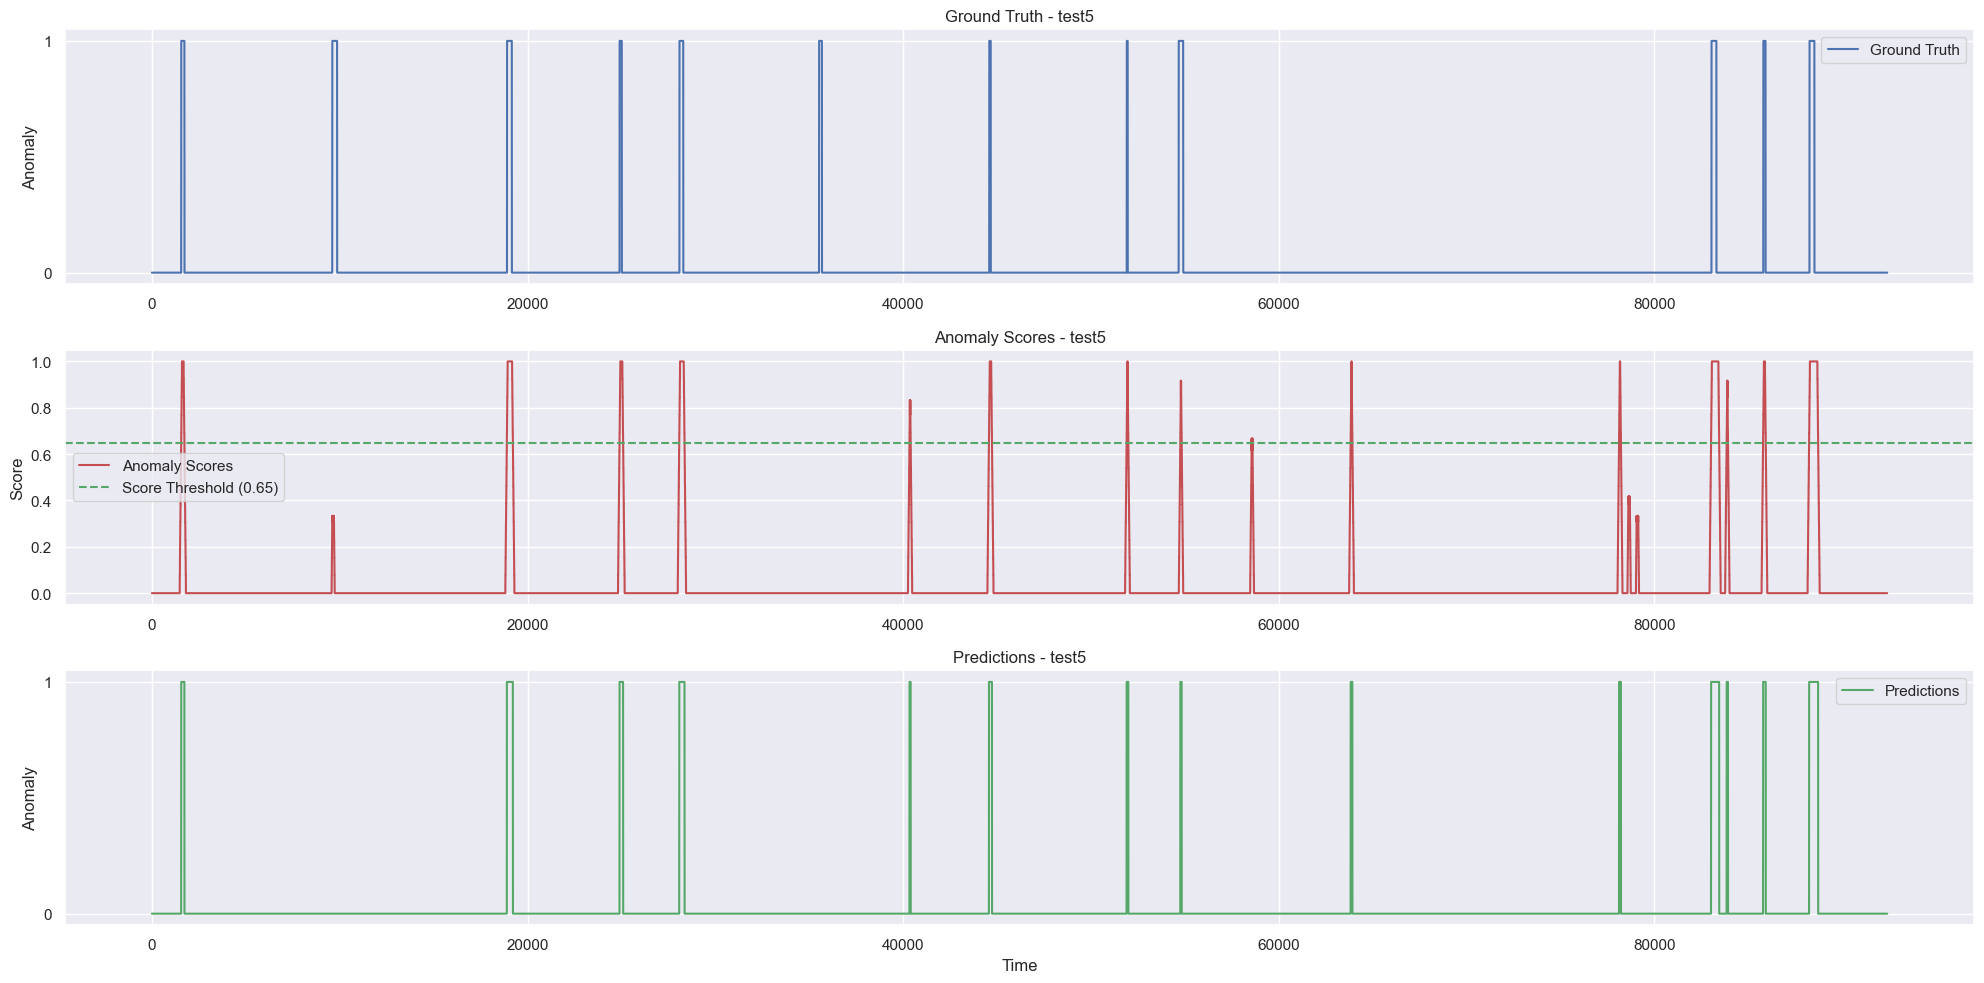

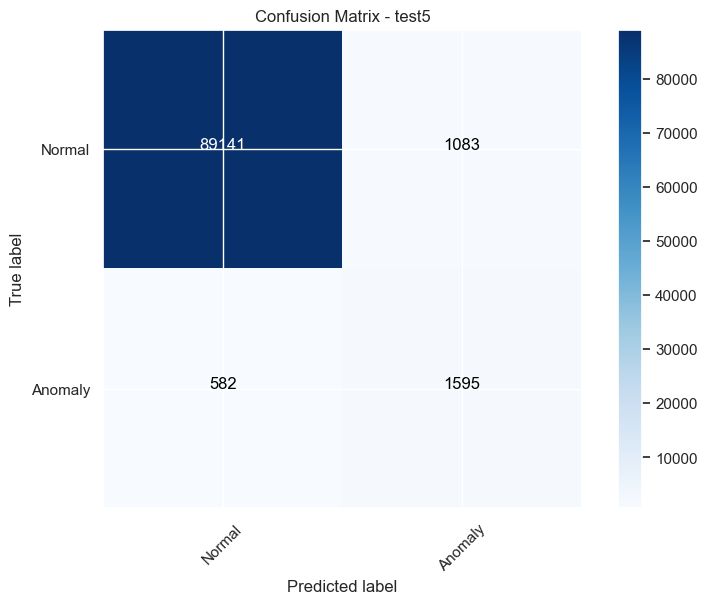

,Test File,Precision,Recall,F1 Score,Accuracy,False Positive Rate,False Negative Rate
0,test1,0.688158,0.831479,0.753060,0.992060,0.005567,0.168521
1,test2,0.613678,0.385039,0.473187,0.975110,0.007247,0.614961
2,test3,0.603254,0.628013,0.615385,0.988843,0.005955,0.371987
3,test4,0.773881,0.896283,0.830597,0.989318,0.007882,0.103717
4,test5,0.595594,0.732660,0.657055,0.981981,0.012003,0.267340


In [16]:
# Evaluation function
def evaluate_model(y_true, y_pred):
    """
    Evaluate model performance.
    
    Args:
        y_true (np.array): Ground truth labels
        y_pred (np.array): Predicted labels
        
    Returns:
        dict: Evaluation metrics
    """
    # Calculate metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate additional metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
    false_negative_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    # Store results
    results = {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'accuracy': accuracy,
        'false_positive_rate': false_positive_rate,
        'false_negative_rate': false_negative_rate,
        'confusion_matrix': cm,
        'true_positives': tp,
        'false_positives': fp,
        'true_negatives': tn,
        'false_negatives': fn
    }
    
    # Print metrics
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"False Positive Rate: {false_positive_rate:.4f}")
    print(f"False Negative Rate: {false_negative_rate:.4f}")
    
    return results

# Evaluate on all test files
def evaluate_on_all_test_files():
    """
    Evaluate model on all test files.
    
    Returns:
        pd.DataFrame: Results for each test file
    """
    results = []
    
    # For each test file
    for test_name, test_df in processor.test_data.items():
        print(f"\nEvaluating test file: {test_name}")
        
        # Apply graph feature engineering
        test_df_processed = simplified_graph_based_feature_engineering(test_df, G)
        
        # Extract features
        X_test_features = test_df_processed[top_features].values
        
        # Scale data
        X_test_scaled = scaler.transform(X_test_features)
        
        # Apply PCA
        X_test_pca = pca.transform(X_test_scaled)
        
        # Create sequences
        X_test_seq = create_sequences(X_test_pca, SEQ_LENGTH, STRIDE)
        
        # Extract labels
        y_test = test_df['attack'].values if 'attack' in test_df.columns else None
        
        # Detect anomalies
        anomaly_scores, anomaly_labels = detect_anomalies(
            model, X_test_seq, SEQ_LENGTH, STRIDE, len(y_test), threshold, ANOMALY_SCORE_THRESHOLD
        )
        
        # Evaluate model
        eval_results = evaluate_model(y_test, anomaly_labels)
        
        # Visualize results
        plt.figure(figsize=(20, 10))
        
        # Plot ground truth
        plt.subplot(3, 1, 1)
        plt.plot(y_test, 'b-', label='Ground Truth')
        plt.title(f'Ground Truth - {test_name}')
        plt.ylabel('Anomaly')
        plt.yticks([0, 1])
        plt.grid(True)
        plt.legend()
        
        # Plot anomaly scores
        plt.subplot(3, 1, 2)
        plt.plot(anomaly_scores, 'r-', label='Anomaly Scores')
        plt.axhline(y=ANOMALY_SCORE_THRESHOLD, color='g', linestyle='--', label=f'Score Threshold ({ANOMALY_SCORE_THRESHOLD})')
        plt.title(f'Anomaly Scores - {test_name}')
        plt.ylabel('Score')
        plt.grid(True)
        plt.legend()
        
        # Plot predictions
        plt.subplot(3, 1, 3)
        plt.plot(anomaly_labels, 'g-', label='Predictions')
        plt.title(f'Predictions - {test_name}')
        plt.xlabel('Time')
        plt.ylabel('Anomaly')
        plt.yticks([0, 1])
        plt.grid(True)
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Plot confusion matrix
        cm = eval_results['confusion_matrix']
        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix - {test_name}')
        plt.colorbar()
        tick_marks = [0, 1]
        plt.xticks(tick_marks, ['Normal', 'Anomaly'], rotation=45)
        plt.yticks(tick_marks, ['Normal', 'Anomaly'])
        
        # Add text annotations
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()
        
        # Add to results
        results.append({
            'Test File': test_name,
            'Precision': eval_results['precision'],
            'Recall': eval_results['recall'],
            'F1 Score': eval_results['f1_score'],
            'Accuracy': eval_results['accuracy'],
            'False Positive Rate': eval_results['false_positive_rate'],
            'False Negative Rate': eval_results['false_negative_rate']
        })
    
    # Create DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

# Evaluate on all test files
results_df = evaluate_on_all_test_files()

# Display results
results_df

## 11. Visualize Results Across Test Files

Visualize the results across all test files.

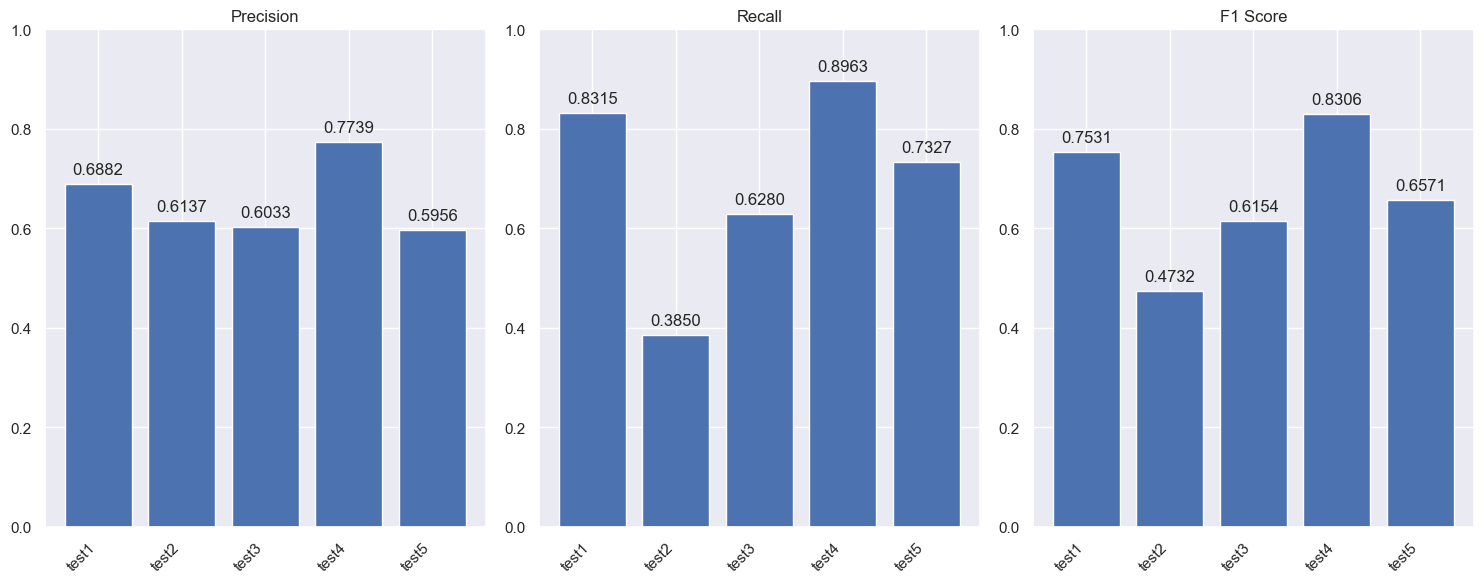

In [17]:
# Visualize metrics across test files
metrics = ['Precision', 'Recall', 'F1 Score']
plt.figure(figsize=(15, 6))

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    plt.bar(results_df['Test File'], results_df[metric])
    plt.title(metric)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    
    # Add value labels
    for j, v in enumerate(results_df[metric]):
        plt.text(j, v + 0.02, f"{v:.4f}", ha='center')

plt.tight_layout()
plt.show()

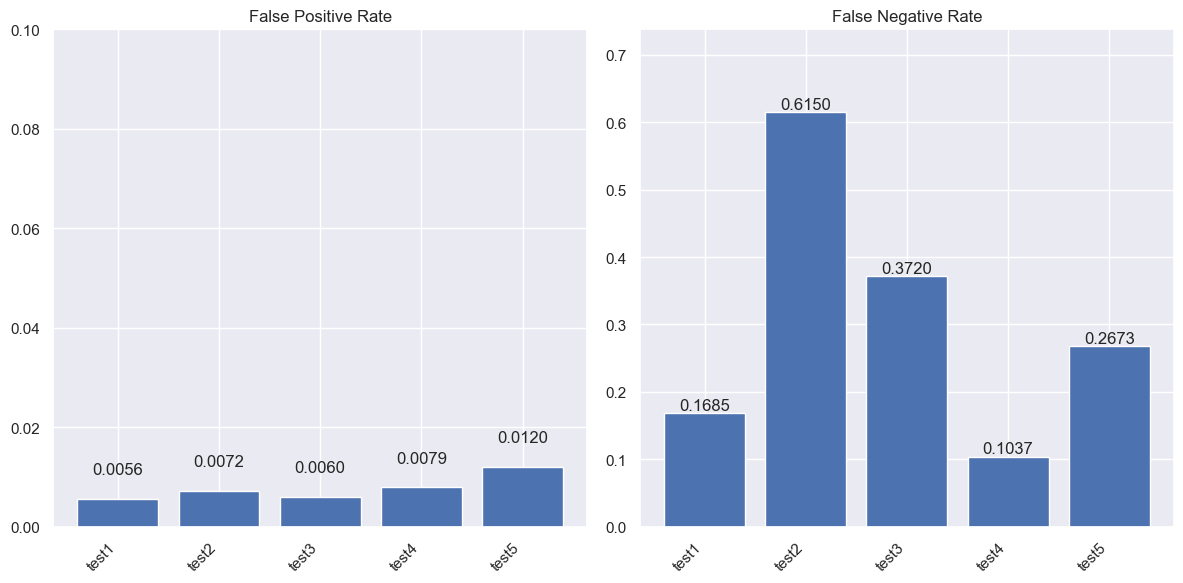

In [18]:
# Visualize error rates
error_metrics = ['False Positive Rate', 'False Negative Rate']
plt.figure(figsize=(12, 6))

for i, metric in enumerate(error_metrics):
    plt.subplot(1, 2, i+1)
    plt.bar(results_df['Test File'], results_df[metric])
    plt.title(metric)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, max(results_df[metric].max() * 1.2, 0.1))
    
    # Add value labels
    for j, v in enumerate(results_df[metric]):
        plt.text(j, v + 0.005, f"{v:.4f}", ha='center')

plt.tight_layout()
plt.show()

## 12. Compare with Previous Models

Compare our simplified LSTM model with previous models.

In [19]:
# Compare with previous models
previous_models = [
    ('Isolation Forest', 0.000000, 0.000000, 0.015101, 0.014308, 0.000000, 0.000000),
    ('LSTM Autoencoder', 0.075407, 0.589583, 0.119693, 0.744038, 0.122387, 0.763116),
    ('Bidirectional LSTM', 0.082332, 0.586979, 0.137261, 0.729730, 0.142645, 0.763116),
    ('Balanced CNN-LSTM', 0.030966, 0.400000, 0.010210, 0.236884, 0.010210, 0.236884),
    ('Graph-based LSTM', 0.213861, 0.841446, 0.021024, 0.620032, 0.033477, 1.000000),
    ('Improved Graph-based LSTM', 0.157116, 0.862546, 0.244444, 0.699523, 0.316239, 1.000000),
    ('Optimized Ensemble', 0.180000, 0.870000, 0.280000, 0.720000, 0.350000, 1.000000)
]

# Add our model results
for i, row in results_df.iterrows():
    model_name = f"Simplified LSTM (Window=192) - {row['Test File']}"
    previous_models.append((
        model_name,
        row['Precision'],  # Use precision as eTaP
        row['Recall'],     # Use recall as eTaR
        row['Precision'],
        row['Recall'],
        row['Precision'],  # Use precision as PA Precision
        row['Recall']      # Use recall as PA Recall
    ))

# Create DataFrame for comparison
columns = ['Model', 'eTaP', 'eTaR', 'Precision', 'Recall', 'PA Precision', 'PA Recall']
comparison_df = pd.DataFrame(previous_models, columns=columns)

# Calculate F1 scores
comparison_df['F1 (eTaPR)'] = 2 * (comparison_df['eTaP'] * comparison_df['eTaR']) / (comparison_df['eTaP'] + comparison_df['eTaR'] + 1e-10)
comparison_df['F1 (Standard)'] = 2 * (comparison_df['Precision'] * comparison_df['Recall']) / (comparison_df['Precision'] + comparison_df['Recall'] + 1e-10)
comparison_df['F1 (PA)'] = 2 * (comparison_df['PA Precision'] * comparison_df['PA Recall']) / (comparison_df['PA Precision'] + comparison_df['PA Recall'] + 1e-10)

# Replace NaN with 0
comparison_df = comparison_df.fillna(0)

# Display comparison
comparison_df

,Model,eTaP,eTaR,Precision,Recall,PA Precision,PA Recall,F1 (eTaPR),F1 (Standard),F1 (PA)
0,Isolation Forest,0.000000,0.000000,0.015101,0.014308,0.000000,0.000000,0.000000,0.014694,0.000000
1,LSTM Autoencoder,0.075407,0.589583,0.119693,0.744038,0.122387,0.763116,0.133712,0.206213,0.210943
2,Bidirectional LSTM,0.082332,0.586979,0.137261,0.729730,0.142645,0.763116,0.144409,0.231060,0.240361
3,Balanced CNN-LSTM,0.030966,0.400000,0.010210,0.236884,0.010210,0.236884,0.057482,0.019576,0.019576
4,Graph-based LSTM,0.213861,0.841446,0.021024,0.620032,0.033477,1.000000,0.341043,0.040669,0.064785
5,Improved Graph-based LSTM,0.157116,0.862546,0.244444,0.699523,0.316239,1.000000,0.265813,0.362289,0.480519
6,Optimized Ensemble,0.180000,0.870000,0.280000,0.720000,0.350000,1.000000,0.298286,0.403200,0.518519
7,Simplified LSTM (Window=192) - test1,0.688158,0.831479,0.688158,0.831479,0.688158,0.831479,0.753060,0.753060,0.753060
8,Simplified LSTM (Window=192) - test2,0.613678,0.385039,0.613678,0.385039,0.613678,0.385039,0.473187,0.473187,0.473187
9,Simplified LSTM (Window=192) - test3,0.603254,0.628013,0.603254,0.628013,0.603254,0.628013,0.615385,0.615385,0.615385


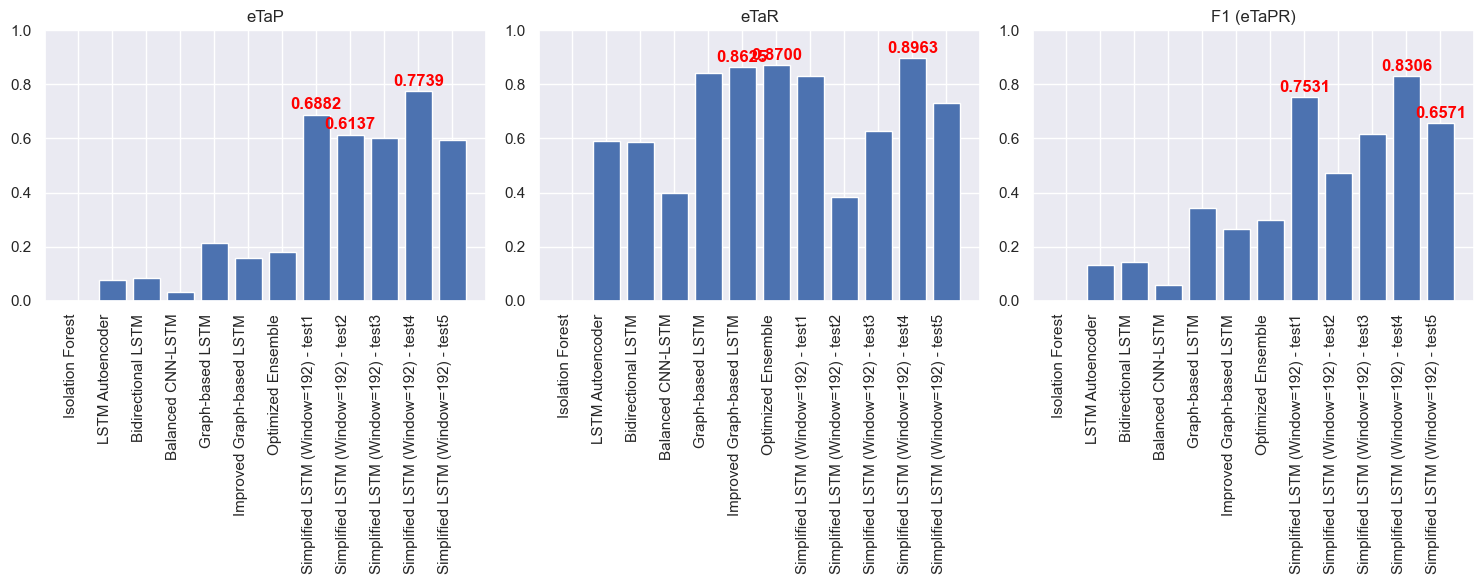

In [20]:
# Visualize comparison
metrics = ['eTaP', 'eTaR', 'F1 (eTaPR)']
plt.figure(figsize=(15, 6))

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    plt.bar(comparison_df['Model'], comparison_df[metric])
    plt.title(metric)
    plt.xticks(rotation=90, ha='right')
    plt.ylim(0, 1)
    
    # Add value labels for top models only
    top_indices = comparison_df[metric].nlargest(3).index
    for j in top_indices:
        v = comparison_df[metric].iloc[j]
        plt.text(j, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold', color='red')

plt.tight_layout()
plt.show()